#### Exploratory analysis of Google Maps reviews in California

In [1]:
# My Github: https://github.com/agrawalreva
# Dataset from Professor Julian McAuley's lab: https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
from pathlib import Path

In [2]:
# load ratings csv
ratings = pd.read_csv('rating-California.csv.gz', compression='gzip', nrows=50000)
ratings = ratings.rename(columns={'user': 'user_id', 'business': 'item_id'})
print(f"Ratings shape: {ratings.shape}")

Ratings shape: (50000, 4)


In [3]:
# load reviews json
def parse_json_gz(path):
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                yield json.loads(line)
reviews_list = []
for rec in parse_json_gz('review-California_10.json.gz'):
    item_id = rec.get('item_id') or rec.get('business_id') or rec.get('gmap_id')
    reviews_list.append({'user_id': rec.get('user_id'),'item_id': item_id,'rating': rec.get('rating'), 'text': rec.get('text', '')})
    if len(reviews_list) >= 50000:
        break
reviews = pd.DataFrame(reviews_list)
reviews = reviews.dropna(subset=['user_id', 'item_id'])  # remove rows with missing keys
print(f"Reviews shape: {reviews.shape}")

Reviews shape: (50000, 4)


In [4]:
# check data types
print(pd.concat([ratings.dtypes, reviews.dtypes], axis=1, keys=["Ratings", "Reviews"]))

          Ratings Reviews
item_id    object  object
user_id    object  object
rating      int64   int64
timestamp   int64     NaN
text          NaN  object


In [5]:
# function to analyze rating distribution
def analyze_ratings(df, col='rating'):
    stats = {'mean': df[col].mean(),'median': df[col].median(),'std': df[col].std(),'min': df[col].min(),'max': df[col].max(),'count': df[col].count()}
    return stats

In [6]:
# merge and clean using ratings as main dataset since it's more complete
merged = ratings.copy()
merged = merged.dropna(subset=['user_id', 'item_id', 'rating'])
merged = merged[merged['rating'] >= 1]
merged = merged[merged['rating'] <= 5]
# add review text where available
merged = merged.merge(reviews[['user_id', 'item_id', 'text']], on=['user_id', 'item_id'], how='left')
print(f"Merged shape: {merged.shape}")

Merged shape: (64302, 5)


In [7]:
# compute stats
review_stats = analyze_ratings(reviews)
merged_stats = analyze_ratings(merged)
print(f"{'Metric':<8} {'Revews':>10} {'Merged':>10}")
for key in review_stats.keys():
    r_val = round(review_stats[key], 2) if isinstance(review_stats[key], float) else review_stats[key]
    m_val = round(merged_stats[key], 2) if isinstance(merged_stats[key], float) else merged_stats[key]
    print(f"{key:<8} {r_val:>10} {m_val:>10}")

Metric       Revews     Merged
mean           4.33       4.42
median          5.0        5.0
std            1.21       1.24
min               1          1
max               5          5
count         50000      64302


In [8]:
# aggregate by user
user_stats = merged.groupby('user_id').agg({'rating': ['mean', 'count'],'item_id': 'nunique'}).reset_index()
user_stats.columns = ['user_id', 'avg_rating', 'num_reviews', 'unique_items']
user_stats = user_stats[user_stats['num_reviews'] >= 3]  # filter active users
print(f"Active users: {len(user_stats)}")
print(user_stats.head())

Active users: 972
                   user_id  avg_rating  num_reviews  unique_items
9    100004002738786778142         5.0            8             1
101  100046346005681618371         5.0            9             5
151  100070016700608101824         5.0            4             2
274  100115858105268784499         5.0            4             2
373  100155668858528438358         5.0            8             1


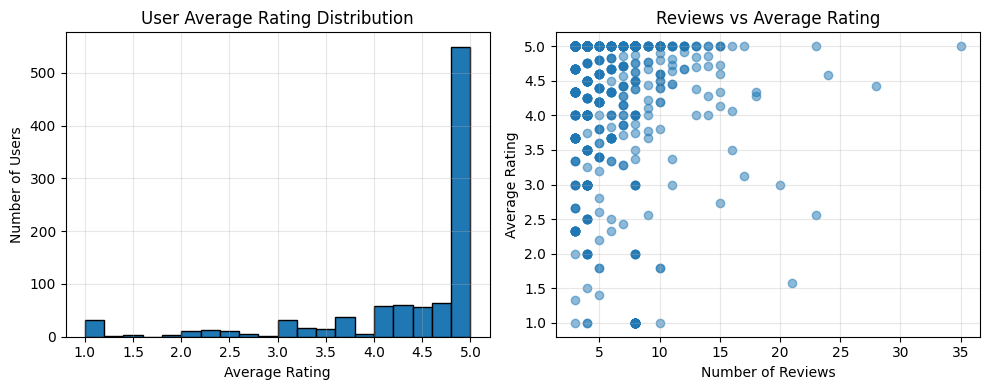

In [9]:
# visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
user_stats['avg_rating'].hist(bins=20, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.title('User Average Rating Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(user_stats['num_reviews'], user_stats['avg_rating'], alpha=0.5)
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.title('Reviews vs Average Rating')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()